<a href="https://colab.research.google.com/github/GGlivePh/BSF_Phenotyping_pipelines/blob/main/AAprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/GGlivePh/BSF_Phenotyping_pipelines.git

Cloning into 'BSF_Phenotyping_pipelines'...
remote: Enumerating objects: 2784, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 2784 (delta 1), reused 0 (delta 0), pack-reused 2777 (from 1)
Receiving objects: 100% (2784/2784), 261.38 MiB | 17.94 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Filtering content: 100% (2202/2202), 716.96 MiB | 17.42 MiB/s, done.


In [2]:
import os
os.chdir('BSF_Phenotyping_pipelines')

In [3]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import os



In [4]:
# Load the data
file_path = "Combined_Scan_Protein_Clean_tFAA.txt"
data = pd.read_csv(file_path, sep="\t")

# Spectral data: column 23 onwards
X_raw = data.iloc[:, 22:].values
X_sg = savgol_filter(X_raw, window_length=21, polyorder=2, deriv=1, axis=1)
X_snv = (X_sg - X_sg.mean(axis=1, keepdims=True)) / X_sg.std(axis=1, keepdims=True)

# Define traits (columns 3 to 22)
traits = data.columns[2:22]
wavelengths = [float(w.replace("X", "")) for w in data.columns[22:]]

# VIP calculation function
def calculate_vip(pls, X, Y):
    t = pls.x_scores_
    w = pls.x_weights_
    q = pls.y_loadings_
    s = np.diag(t.T @ t @ q.T @ q)
    total_s = sum(s)
    vip = np.sqrt(X.shape[1] * ((w**2) @ s.reshape(-1, 1)).flatten() / total_s)
    return vip

results = []
vip_all = []

# Try a few traits first, then scale
for trait in traits[:2]:  # change to traits if need to analyse all
    y = data[trait].values
    if len(np.unique(y)) < 2:
        continue

    X_train, X_test, y_train, y_test = train_test_split(X_snv, y, test_size=0.25, random_state=42)

    # Tune number of components
    best_r2, best_n = -np.inf, 1
    for n in range(1, 16):
        pls = PLSRegression(n_components=n)
        scores = cross_val_score(pls, X_train, y_train, cv=KFold(5), scoring='r2')
        if np.mean(scores) > best_r2:
            best_r2 = np.mean(scores)
            best_n = n

    pls = PLSRegression(n_components=best_n)
    pls.fit(X_train, y_train)
    y_pred = pls.predict(X_test).ravel()

    R2 = r2_score(y_test, y_pred)
    SECV = np.sqrt(mean_squared_error(y_train, pls.predict(X_train)))
    SEP = np.sqrt(mean_squared_error(y_test, y_pred))
    RPD = np.std(y_test) / SECV
    Bias = np.mean(y_test - y_pred)
    Slope = np.polyfit(y_test, y_pred, 1)[0]

    results.append([trait, R2, SECV, SEP, RPD, Bias, Slope])

    vip = calculate_vip(pls, X_train, y_train)
    vip_df = pd.DataFrame({
        "Wavelength": data.columns[22:],
        "NumericWavelength": wavelengths,
        "VIP_Score": vip,
        "Trait": trait
    })
    vip_all.append(vip_df)



In [5]:
# Display results as a table in Colab
import pandas as pd
from IPython.display import display

results_df = pd.DataFrame(results, columns=["Trait", "R2", "SECV", "SEP", "RPD", "Bias", "Slope"])
results_df = results_df.sort_values(by="R2", ascending=False).reset_index(drop=True)
display(results_df.style.format({"R2": "{:.2f}", "SECV": "{:.2f}", "SEP": "{:.2f}", "RPD": "{:.2f}", "Bias": "{:.2f}", "Slope": "{:.2f}"}))


,Trait,R2,SECV,SEP,RPD,Bias,Slope
0,Alanine,0.65,2.25,2.26,1.71,0.25,0.54
1,Arginine,0.57,0.50,0.61,1.85,0.13,0.54


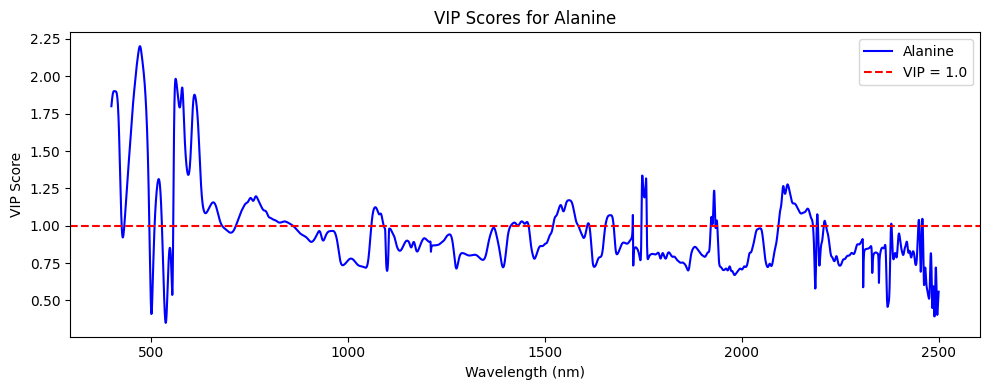

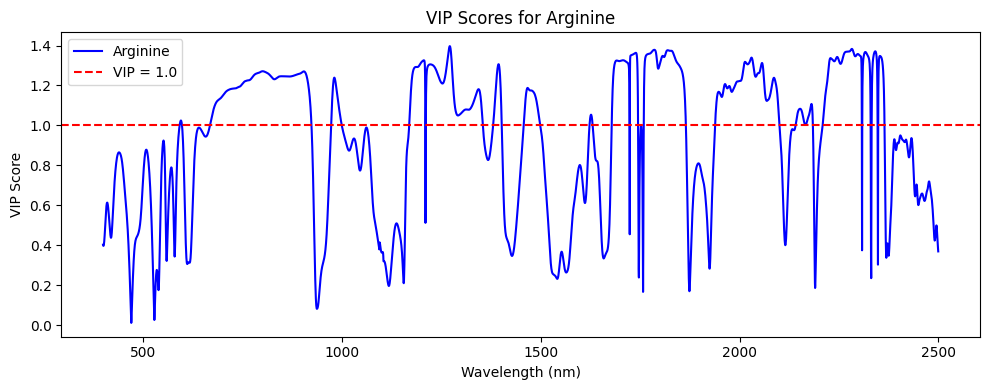

In [6]:
# Display VIP plots in Colab
import matplotlib.pyplot as plt

for vip_df in vip_all:
    trait = vip_df["Trait"].iloc[0]
    plt.figure(figsize=(10, 4))
    plt.plot(vip_df["NumericWavelength"], vip_df["VIP_Score"], color="blue", label=trait)
    plt.axhline(y=1.0, color='red', linestyle='--', label='VIP = 1.0')
    plt.title(f"VIP Scores for {trait}")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("VIP Score")
    plt.legend()
    plt.tight_layout()
    plt.show()
